In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
data_path = 'train.tfrecords'  # address to save the hdf5 file

def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)


def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [35]:
x = tf.placeholder(tf.float32,shape=[None,30000])

y_true = tf.placeholder(tf.float32,shape=[None,2])

### Layers

x_image = tf.reshape(x,[-1,100,100,3])

# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of 
# a single image.
convo_1 = convolutional_layer(x_image,shape=[6,6,3,32])
print(convo_1.get_shape())
convo_1_pooling = max_pool_2by2(convo_1)
print(convo_1_pooling.get_shape())

# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
print(convo_2.get_shape())
convo_2_pooling = max_pool_2by2(convo_2)
print(convo_2_pooling.get_shape())
# Why 7 by 7 image? Because we did 2 pooling layers, so (28/2)/2 = 7
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
print(convo_2_flat.get_shape())
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
print(full_layer_one.get_shape())
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
print(full_one_dropout.get_shape())
y_pred = normal_full_layer(full_one_dropout,10)
print(y_pred.get_shape())

(?, 100, 100, 32)
(?, 50, 50, 32)
(?, 50, 50, 64)
(?, 25, 25, 64)
(?, 3136)
(?, 1024)
(?, 1024)
(?, 10)


In [36]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
print(cross_entropy.get_shape())

### Optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

init = tf.global_variables_initializer()

### Session

steps = 5000

()


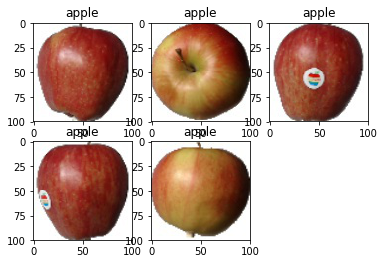

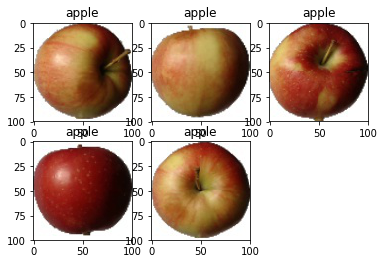

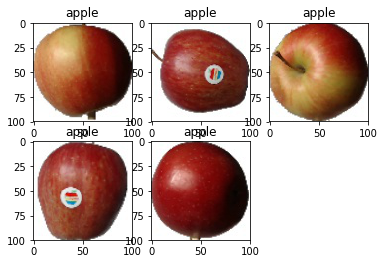

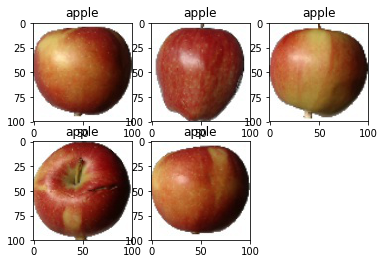

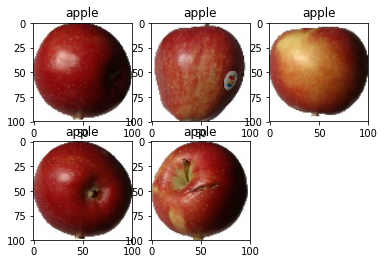

In [38]:
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)

    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [100, 100, 3])

    # Any preprocessing here ...

    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=5, capacity=5, num_threads=1, min_after_dequeue=1)

    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        #sess.run(train,feed_dict={x:img,y_true:lbl,hold_prob:0.5})
        img = img.astype(np.uint8)
        for j in range(5):
            plt.subplot(2, 3, j + 1)
            plt.imshow(img[j, ...])
            plt.title('apple' if lbl[j] == 1 else 'not apple')
        plt.show()
    # Stop the threads
    coord.request_stop()

    # Wait for threads to stop
    coord.join(threads)
    sess.close()